![](./resources/System_v1_custom_croptype.png)

**Table of contents**<a id='toc0_'></a>    
- [Before you start](#toc1_)    
- [Define a region of interest](#toc2_)    
- [Extract public training data](#toc3_)    
- [Select desired crops for prediction](#toc4_)    
- [Extract required model inputs](#toc5_)    
- [Train custom classification model](#toc6_)    
- [Deploy custom model](#toc7_)    
- [Generate a map](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Before you start](#toc0_)

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the Copernicus Data Space Ecosystem (CDSE) registering [here](https://dataspace.copernicus.eu/). This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

In [1]:
# TEMPORARY CELL

import sys
sys.path.append('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/notebooks')
%load_ext autoreload
%autoreload 2

# <a id='toc2_'></a>[Define a region of interest](#toc0_)

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
Currently, there is a maximum size of 250 km² for your area within this demo. Upon exceeding this limit, an error will be shown.
The widget will automatically store the coordinates of the last rectangle you drew on the map

In [2]:
from worldcereal.utils.map import ui_map

map = ui_map()
map.show_map()

Map(center=[51.1872, 5.1154], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

2024-10-11 09:45:32.837 | INFO     | worldcereal.utils.map:handle_draw:13 - Your processing extent: (2.689934, 47.181313, 2.790527, 47.222366)
2024-10-11 09:45:32.912 | INFO     | worldcereal.utils.map:handle_draw:19 - Area of processing extent: 35.02 km²


# <a id='toc3_'></a>[Extract public training data](#toc0_)

Here we query existing reference data that have already been processed by WorldCereal and are ready to use.
To increase the number of hits, we expand the search area by 250 km in all directions.

In [4]:
from worldcereal.utils.refdata import query_public_extractions

# retrieve the polygon you just drew
polygon = map.get_polygon_latlon()

# Query our public database of training data
public_df = query_public_extractions(polygon)

2024-10-11 09:49:03.914 | INFO     | worldcereal.utils.map:get_processing_extent:107 - Your processing extent: (2.689934, 47.181313, 2.790527, 47.222366)
2024-10-11 09:49:03.916 | INFO     | worldcereal.utils.refdata:query_public_extractions:51 - Applying a buffer of 250 km to the selected area ...
2024-10-11 09:49:04.051 | INFO     | worldcereal.utils.refdata:query_public_extractions:82 - Querying WorldCereal global extractions database (this can take a while) ...
2024-10-11 09:49:22.269 | INFO     | worldcereal.utils.refdata:process_parquet:128 - Processing selected samples ...
2024-10-11 09:49:22.978 | INFO     | worldcereal.utils.refdata:process_parquet:131 - Extracted and processed 5877 samples from global database.


# <a id='toc4_'></a>[Select desired crops for prediction](#toc0_)

Crops with ticked checkboxes will be included in the prediction. All the crops that are not selected will be grouped under the "other_crop" category. The model will be trained in a multi-class setting.

In [5]:
from utils import pick_croptypes
from IPython.display import display

checkbox, checkbox_widgets = pick_croptypes(public_df, samples_threshold=100)
display(checkbox)

Based on your selection, a custom target label is now generated for each sample. Verify that only crops of your choice are appearing in the `custom_class`, all others will fall under `other`.

In [6]:
from utils import get_custom_labels

public_df = get_custom_labels(public_df, checkbox_widgets)
public_df["downstream_class"].value_counts()

downstream_class
unspecified_wheat     2329
other                 2085
unspecified_barley     855
rapeseed_rape          608
Name: count, dtype: int64

# <a id='toc5_'></a>[Extract required model inputs](#toc0_)

Here we prepare presto inputs features for each sample by using a model pretrained on WorldCereal data. The resulting `encodings` and `targets` will be used for model training.

In [7]:
from utils import get_inputs_outputs

encodings, targets = get_inputs_outputs(public_df)

2024-10-11 09:51:47.100 | INFO     | utils:get_inputs_outputs:261 - Presto URL: https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct-30D_test.pt
2024-10-11 09:51:47.282 | INFO     | utils:get_inputs_outputs:269 - Computing Presto embeddings ...
2024-10-11 09:52:01.535 | INFO     | utils:get_inputs_outputs:292 - Done.


# <a id='toc6_'></a>[Train custom classification model](#toc0_)
We train a catboost model for the selected crop types. Class weights are automatically determined to balance the individual classes.

In [8]:
from utils import train_classifier

custom_model, report, confusion_matrix = train_classifier(encodings, targets)

2024-10-11 09:56:00.159 | INFO     | utils:train_classifier:319 - Split train/test ...
2024-10-11 09:56:00.174 | INFO     | utils:train_classifier:335 - Computing class weights ...
2024-10-11 09:56:00.183 | INFO     | utils:train_classifier:340 - Class weights:
2024-10-11 09:56:00.187 | INFO     | utils:train_classifier:363 - Training CatBoost classifier ...


Learning rate set to 0.050192
0:	learn: 1.3175728	test: 1.3175199	best: 1.3175199 (0)	total: 108ms	remaining: 14m 24s
25:	learn: 0.6652848	test: 0.6872883	best: 0.6872883 (25)	total: 1.05s	remaining: 5m 21s
50:	learn: 0.4904228	test: 0.5411005	best: 0.5411005 (50)	total: 1.98s	remaining: 5m 8s
75:	learn: 0.4074234	test: 0.4843929	best: 0.4843929 (75)	total: 2.87s	remaining: 4m 59s
100:	learn: 0.3546780	test: 0.4576552	best: 0.4576552 (100)	total: 3.78s	remaining: 4m 55s
125:	learn: 0.3174771	test: 0.4411317	best: 0.4411317 (125)	total: 4.74s	remaining: 4m 55s
150:	learn: 0.2878676	test: 0.4317767	best: 0.4317767 (150)	total: 5.68s	remaining: 4m 55s
175:	learn: 0.2626588	test: 0.4253288	best: 0.4253288 (175)	total: 6.61s	remaining: 4m 53s
200:	learn: 0.2439518	test: 0.4194977	best: 0.4194977 (200)	total: 7.55s	remaining: 4m 53s
225:	learn: 0.2267627	test: 0.4159549	best: 0.4159549 (225)	total: 8.59s	remaining: 4m 55s
250:	learn: 0.2110828	test: 0.4137662	best: 0.4137662 (250)	total: 9.5

In [9]:
# Print the classification report
print(report)

                    precision    recall  f1-score   support

             other       0.89      0.86      0.87       626
     rapeseed_rape       0.88      0.92      0.90       182
unspecified_barley       0.70      0.75      0.73       257
 unspecified_wheat       0.87      0.87      0.87       699

          accuracy                           0.85      1764
         macro avg       0.84      0.85      0.84      1764
      weighted avg       0.86      0.85      0.85      1764



# <a id='toc7_'></a>[Deploy custom model](#toc0_)

Once trained, we have to upload our model to the cloud so it can be used for inference. Note that these models are only kept in cloud storage for a limited amount of time.


In [10]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection

model_url = deploy_model(cdse_connection(), custom_model, pattern="demo_croptype_multiclass_FR")

2024-10-11 09:56:46.465 | INFO     | worldcereal.utils.upload:deploy_model:205 - Deploying model ...


Authenticated using refresh token.


2024-10-11 09:56:49.429 | INFO     | worldcereal.utils.upload:deploy_model:211 - Deployed to: s3://OpenEO-artifacts/fd307620ba8a0a07c44a2dc28541b181d5c03cb4/2024/10/11/demo_croptype_multiclass_FR_custommodel.onnx


# <a id='toc8_'></a>[Generate a map](#toc0_)

Using our custom model, we generate a map for our region and season of interest.
To determine your season of interest, you can consult the WorldCereal crop calendars (by executing the next cell), or check out the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

2024-10-11 10:01:21.547 | INFO     | worldcereal.utils.map:get_processing_extent:107 - Your processing extent: (2.689934, 47.181313, 2.790527, 47.222366)


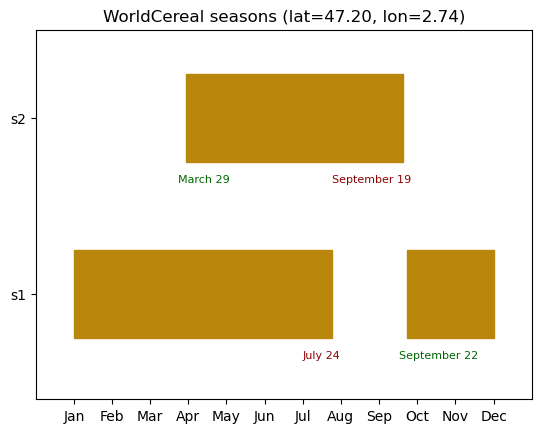

In [11]:
from utils import retrieve_worldcereal_seasons

spatial_extent = map.get_processing_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Now use the slider to select your processing period. Note that the length of the period is always fixed to a year.
Just make sure your season of interest is fully captured within the period you select.

In [12]:
from utils import date_slider

slider = date_slider()
slider.show_slider()

Set some other customization options:

In [13]:
from worldcereal.job import PostprocessParameters
import os
from pathlib import Path

# Choose whether you want to store the cropland mask as separate output file (default = False)
save_mask = True

# Choose whether or not you want to spatially clean the classification results (default = True)
postprocess_result = True
# Choose the postprocessing method you want to use ["smooth_probabilities", "majority_vote"] (default = "smooth_probabilities")
postprocess_method = "majority_vote"
# Additiona parameters for the majority vote method:
kernel_size = 5 # default = 5
conf_threshold = 60 # default = 30
# Do you want to save the intermediate results (before applying the postprocessing)
save_intermediate = True #default is False
# Do you want to save all class probabilities in the final product? (default is False)
keep_class_probs = True

postprocess_parameters = PostprocessParameters(enable=postprocess_result,
                                               method=postprocess_method,
                                               kernel_size=kernel_size,
                                               conf_threshold=conf_threshold,
                                               save_intermediate=save_intermediate,
                                               keep_class_probs=keep_class_probs)

# Specify the local directory where the resulting maps should be downloaded to.
output_dir = Path(os.getcwd()) / 'CROPTYPE_test'
print(f"Output directory: {output_dir}")

Output directory: /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test


In [14]:
from worldcereal.job import WorldCerealProductType, generate_map, CropTypeParameters

# Initializes default parameters
parameters = CropTypeParameters()

# Change the URL to your custom classification model
parameters.classifier_parameters.classifier_url = model_url
parameters.save_mask = save_mask

# Get processing period and area
processing_period = slider.get_processing_period()
processing_extent = map.get_processing_extent()

# Launch the job
job_results = generate_map(
    processing_extent,
    processing_period,
    output_dir=output_dir,
    product_type=WorldCerealProductType.CROPTYPE,
    croptype_parameters=parameters,
    postprocess_parameters=postprocess_parameters,
)

2024-10-11 10:08:13.190 | INFO     | utils:get_processing_period:116 - Selected processing period: 2020-09-01 to 2021-08-31
2024-10-11 10:08:13.277 | INFO     | worldcereal.utils.map:get_processing_extent:107 - Your processing extent: (2.689934, 47.181313, 2.790527, 47.222366)


Authenticated using refresh token.


2024-10-11 10:08:25,067 - openeo_gfmap.utils - INFO - Selected orbit state: DESCENDING. Reason: Orbit has more cumulative intersected area. 1.106744805086367 > 1.0773866182185106


0:00:00 Job 'j-241011ce5eb042ce81b3ddff287777a8': send 'start'
0:00:15 Job 'j-241011ce5eb042ce81b3ddff287777a8': created (progress 0%)
0:00:21 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:00:27 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:00:35 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:00:45 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:00:58 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:01:13 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:01:33 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:01:57 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:02:27 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:03:05 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:03:51 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (progress N/A)
0:04:50 Job 'j-241011ce5eb042ce81b3ddff287777a8': running (pro

INFO:openeo.rest.job:Downloading Job result asset 'cropland-raw_2020-01-01Z.tif' from https://openeo.creo.vito.be/openeo/jobs/j-241011ce5eb042ce81b3ddff287777a8/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/b16fc6f8a948dbabb9f874e121a80de7/cropland-raw_2020-01-01Z.tif?expires=1729240001 to /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/cropland-raw_2020-01-01Z.tif
INFO:openeo.rest.job:Downloading Job result asset 'croptype-raw_2020-01-01Z.tif' from https://openeo.creo.vito.be/openeo/jobs/j-241011ce5eb042ce81b3ddff287777a8/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/d6e7fe06afdefd8cc62f82a1c5caf1b4/croptype-raw_2020-01-01Z.tif?expires=1729240001 to /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype-raw_2020-01-01Z.tif
INFO:openeo.rest.job:Downloading Job result asset 'croptype_2020-01-01Z.tif' from https://openeo.creo.vito.be/openeo/jobs/j-241011ce5eb042ce81b3ddff287777a8/results/a

The classification results will be automatically downloaded to your output_dir in .tif format.
By default, OpenEO stores the class labels, confidence score and class probabilities in one file.

Using the function below, we split this information into separate .tif files, thereby adding metadata and a color map, to ease interpretation and visualization:
- "xxx_classification_start-date_end-date.tif" --> contains the classification labels. A class look-up table is included in the .tif metadata.
- "xxx_confidence_start-date_end-date.tif" -->  contains the probability associated to the prediction [0 - 100]

In case you chose to store the original per-class probabilities, these are NOT written to a separate file and need to be consulted in the original result downloaded from OpenEO.

In [18]:
from utils import prepare_visualization

rasters = prepare_visualization(job_results, processing_period)
print(rasters)

INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='TIFFSetField:/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/cropland-raw_classification_20200901_20210831.tif: Cannot modify tag "PhotometricInterpretation" while writing'
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='TIFFSetField:/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/cropland-raw_confidence_20200901_20210831.tif: Cannot modify tag "PhotometricInterpretation" while writing'
2024-10-11 13:11:00.130 | INFO     | utils:_get_colormap:432 - Assigning random color map for product croptype. 
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='TIFFSetField:/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype-raw_classification_20200901_20210831.tif: Cannot modify tag "PhotometricInterpretation" while writing'
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='TIFFSetField:/home/jeroendegerickx/git/worl

{'cropland-raw': {'classification': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/cropland-raw_classification_20200901_20210831.tif'), 'confidence': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/cropland-raw_confidence_20200901_20210831.tif')}, 'croptype-raw': {'classification': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype-raw_classification_20200901_20210831.tif'), 'confidence': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype-raw_confidence_20200901_20210831.tif')}, 'croptype': {'classification': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype_classification_20200901_20210831.tif'), 'confidence': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype_confidence_20200901_20210831.tif')}}


In [17]:
job_results

InferenceResults(job_id='j-241011ce5eb042ce81b3ddff287777a8', products={'cropland-raw': {'url': 'https://openeo.creo.vito.be/openeo/jobs/j-241011ce5eb042ce81b3ddff287777a8/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/b16fc6f8a948dbabb9f874e121a80de7/cropland-raw_2020-01-01Z.tif?expires=1729240001', 'type': <WorldCerealProductType.CROPLAND: 'cropland'>, 'path': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/cropland-raw_2020-01-01Z.tif'), 'lut': {0: 0, 1: 1}}, 'croptype-raw': {'url': 'https://openeo.creo.vito.be/openeo/jobs/j-241011ce5eb042ce81b3ddff287777a8/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/d6e7fe06afdefd8cc62f82a1c5caf1b4/croptype-raw_2020-01-01Z.tif?expires=1729240001', 'type': <WorldCerealProductType.CROPTYPE: 'croptype'>, 'path': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_test/croptype-raw_2020-01-01Z.tif'), 'lut': {'other': 0, 'rapeseed_rape': 1, 'u

The resulting raster files can be visualized in QGIS, or using the function in the cell below...

In [ ]:
from utils import visualize_products

visualize_products(rasters, port=8889)

Finally, use the cell below to visualize the look-up table for the classification product.

In [ ]:
from utils import show_color_legend

show_color_legend(rasters, "croptype")